<a href="https://colab.research.google.com/github/sujitpal/keras-tutorial-odsc2020/blob/master/03_03_tensorflow_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__NOTE: remember to set your runtime type to GPU for this notebook.__

# Using underlying Tensorflow features

In this session, we will look at some interesting Tensorflow features that you should know as a `tf.keras` developer. The "old" Keras used to provide a set of `keras.backend` functions that would delegate to the appropriate Tensorflow or Theano function.

Because `tf.keras` has only a single backend, the entire Tensorflow library is at your disposal for customizing Keras. The old backend functions are still available via the `tf.keras.backend` package, but chances are very high that it maps 1:1 to an actual TF function.

We will cover the following:
* tf.data.Dataset
* tf.GradientTape and @tf.function
* Distributed training using tf.strategy

Finally, we will cover some strategies for exploring further and keeping up-to-date on Keras.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

import time

%matplotlib inline

## tf.data.Dataset

Tensorflow allows you to create iterators over your data, and Keras can consume these Dataset objects instead of Numpy matrices (such as `(Xtrain, ytrain)` pairs we were using so far).

You can create Datasets from various things, [full list is here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), common ones are:

* `Dataset.from_tensor_slices`
* `Dataset.from_generator`
* `tf.data.TFRecordDataset` objects ([see docs](https://www.tensorflow.org/guide/data#consuming_tfrecord_data)).

Dataset is an iterator, so full dataset does not need to fit in memory.

General pattern:
* Create dataset from input data.
* Apply transformations (shuffle, batch, etc) on the data.
* Consume the data in streaming manner.


### Dataset.from_tensor_slices()

In [2]:
(Xtrain, ytrain), _ = keras.datasets.mnist.load_data()

Xtrain = Xtrain.reshape(Xtrain.shape[0], 28, 28, 1).astype(np.float32)
ytrain = keras.utils.to_categorical(ytrain, num_classes=10)

train_ds = tf.data.Dataset.from_tensor_slices((Xtrain, ytrain)).shuffle(len(Xtrain)).batch(32)

for Xtrain_b, ytrain_b in train_ds:
  print(Xtrain_b.shape, ytrain_b.shape)
  break

11493376/11490434 [==============================] - 0s 0us/step
(32, 28, 28, 1) (32, 10)


You can also apply various transformations to a dataset. For example, if we want to resize each of these images, we could do something as shown below.

Other transformations are __filter__, __enumerate__, __flat_map__, etc.

Note that the parameter to `lambda` should mirror the structure of the dataset element.

In [3]:
def resize_image(x, y):
  image = tf.image.resize(x, (32, 32))
  return (image, y)

train_ds = tf.data.Dataset.from_tensor_slices((Xtrain, ytrain)).batch(32)
resized_ds = train_ds.map(lambda x, y: resize_image(x, y))
for X, y in resized_ds:
  print(X.shape, y.shape)
  break


(32, 32, 32, 1) (32, 10)


### Dataset.from_generator()

Another option could be to wrap the Keras `ImageDataGenerator` with a Dataset, so that way we have a data stream of augmented images.

* Declare a `ImageDataGenerator`
* Define an iterator using `ImageDataGenerator.flow`.
* Create `Dataset` with `from_generator`, passing the iterator to the function via a lambda.

You can call `repeat(n)` on the Dataset to get the benefit of real data augmentation, i.e. repeat(10) will given you 10x the data (original + random augmented according to your configuration of `ImageDataGenerator`).

In [4]:
image_augmenter = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

BATCH_SIZE = 32
data_generator = image_augmenter.flow(Xtrain, ytrain, batch_size=BATCH_SIZE)

train_ds = tf.data.Dataset.from_generator(
    lambda: data_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([BATCH_SIZE, 28, 28, 1],
                   [BATCH_SIZE, 10])
)

for X, y in train_ds:
  print(X.shape, y.shape)
  break


(32, 28, 28, 1) (32, 10)


In [5]:
Xtrain.shape

(60000, 28, 28, 1)

### Keras preprocessing tools

In addition, Keras provides the following two convenience functions that can convert images and text files into datasets.

* `preprocessing.text_dataset_from_directory` -- [see docs](https://keras.io/api/preprocessing/text/)
* `preprocessing.image_dataset_from_directory` -- [see docs](https://keras.io/api/preprocessing/image/)

Both depend on a standard directory structure that looks like this:

```
directory
  |
  +-- class_label_1
  |    |
  |    +-- item_1 (image or text, one record)
  |    |
  |    +-- ...
  |    |
  |    +-- item_n
  +-- class_labels_2
  |    |
```

In general, though, it is possible to create a Dataset from any generator function using `Dataset.from_generator()`, similar to how we built one from `ImageDataGenerator` (see [consuming Python generators](https://www.tensorflow.org/guide/data#consuming_python_generators)) for details.

## tf.GradientTape and @tf.function

When you need more control over the training loop than calling `fit` on your Keras model, then you can use `tf.GradientTape` which allows for automatic differentiation.

The `@tf.function` annotation is meant to put the training loop in "compiled-mode", i.e., in non-eager mode.

A good example for when you might want more control over the training loop is with a Generative Adversarial Network (GAN).

### Generative Adversarial Network (GAN)

A GAN consists of __two competing networks__ -- a generator and a discriminator - that are trained in an __adversarial manner__.

Generator learns to create output that looks real, and discriminator learns to tell real from fake output.

As training progresses, generator learns to create output that looks more and more real, and discriminator gets better at telling them apart.

The training converges when there is no more improvement in the discriminator.

The example here is adapted from the [Tensorflow tutorial on DCGAN](https://www.tensorflow.org/tutorials/generative/dcgan).

In [6]:
# NOTE: we are not using labels here, at all
(Xtrain, _), (_, _) = keras.datasets.mnist.load_data()

Xtrain.shape

(60000, 28, 28)

In [7]:
NOISE_DIM = 100
BATCH_SIZE = 256
NUM_EPOCHS = 50

In [8]:
# reshape images to add channel and set type to float
Xtrain = Xtrain.reshape(Xtrain.shape[0], 28, 28, 1).astype(np.float32)

# normalize pixel values to the range [-1, 1]
Xtrain = (Xtrain - 127.5) / 127.5

# convert to tf Dataset
train_ds = tf.data.Dataset.from_tensor_slices(Xtrain).shuffle(len(Xtrain)).batch(BATCH_SIZE)

Both the generator and discriminator are convolutional models.

The [Conv2DTranspose layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) is the inverse operation of Convolution, and is sometimes called Deconvolution. Instead of summarizing an area of the image into a smaller but deeper tensor, it expands a small deep tensor into a flatter larger one.

So the generator takes a (batch of) random vectors and tries to produce a (batch of) images of shape (None, 28, 28, 1), here None is the batch dimension.

The discriminator takes the generated image and tries to predict a number between 0 and 1, which gets converted to 0 (fake) or 1 (true) by the Binary Cross Entropy loss function.


### Models

In [9]:
def build_generator():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(keras.layers.Conv2DTranspose(
        128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(
        64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(
        1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


def build_discriminator():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1]))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model


### Loss functions and optimizers

The discriminator loss quantifies how well discriminator is able to distinguish real from fake, so it is a combination of the difference between discriminator predictions on real images to an array of 1s, and discriminator predictions on fake (generated) images to an array of 0s.

The generator loss quantifies how well it was able to trick the discriminator. So if generator is performing well, it should be able to trick the discriminator completely. So the loss is measured as the difference between the discriminator predictions against fake images generated by generator against an array of 1s.

For both generator and discriminator, the optimizer we choose is Adam with learning rate 1e-4.

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Training loop

Notice the following:

* You have to specify `training=True` for the discriminator and generator. In (high level) Keras, this is set by Keras depending on whether you call `fit` or `predict` (or `evaluate`).
* You have to compute the loss by applying the appropriate loss function to the output of the model.
* You have to compute and apply the gradient of the loss back into the model using `optimizer.apply_gradients()`.

The `train` function just calls the `train_step` function for the given number of epochs and writes out some progress information.

In [11]:
@tf.function
def train_step(images, generator, discriminator):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))


In [12]:
def train(dataset, generator, discriminator, num_epochs):
  for epoch in range(num_epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch, generator, discriminator)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [13]:
generator = build_generator()
discriminator = build_discriminator()

train(train_ds, generator, discriminator, NUM_EPOCHS)

Time for epoch 1 is 18.251754999160767 sec
Time for epoch 2 is 9.9715256690979 sec
Time for epoch 3 is 9.979154109954834 sec
Time for epoch 4 is 10.042799234390259 sec
Time for epoch 5 is 10.095405340194702 sec
Time for epoch 6 is 10.172830581665039 sec
Time for epoch 7 is 10.211159706115723 sec
Time for epoch 8 is 10.259447574615479 sec
Time for epoch 9 is 10.304327487945557 sec
Time for epoch 10 is 10.365758419036865 sec
Time for epoch 11 is 10.400451183319092 sec
Time for epoch 12 is 10.427586555480957 sec
Time for epoch 13 is 10.449369430541992 sec
Time for epoch 14 is 10.475065469741821 sec
Time for epoch 15 is 10.502979278564453 sec
Time for epoch 16 is 10.544360399246216 sec
Time for epoch 17 is 10.553219556808472 sec
Time for epoch 18 is 10.584198951721191 sec
Time for epoch 19 is 10.602518796920776 sec
Time for epoch 20 is 10.598242044448853 sec
Time for epoch 21 is 10.636535406112671 sec
Time for epoch 22 is 10.638715028762817 sec
Time for epoch 23 is 10.648664951324463 sec
T

### What has the generator learned?

The generator has learned how to take random input and produce images that look like MNIST digits.

We give it a set of random vectors of size `NOISE_DIM=100` and call the generator with `training=False` to get our generated images.

As you can see, the generated images kind of look like digits.

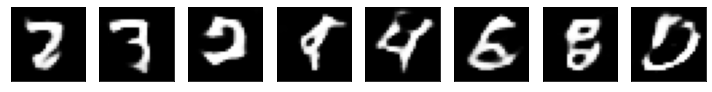

In [14]:
num_examples_to_generate = 8
seeds = tf.random.normal([num_examples_to_generate, NOISE_DIM])
preds = generator(seeds, training=False)

plt.figure(figsize=(10, 5))
for i in range(preds.shape[0]):
  plt.subplot(1, 8, i+1)
  plt.imshow(preds[i, :, :, 0], cmap="gray")
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
_ = plt.show()


## Distributed Training

Keras (and Tensorflow) allows you to define `strategies` to do distributed training. We will cover training on multiple GPUs on a single machine.

This is the most common use case. AWS provides various GPU instances with upto 16 GPUs (P2, P3, G3, G4).

Main approaches for distributing training:
  * Data Parallelism -- model trains using part of the data on each GPU.
  * Model Parallelism -- sub-models trained separately on each GPU.

Two requirements:
* For fault tolerance, it is recommended to use `ModelCheckpoint` callback to save the model periodically.
* Also distributed training needs data to be provided as `tf.data.Datasets`.

You can also train across a cluster of GPU enabled machines -- [see this document for more details](https://keras.io/guides/distributed_training/).

In [15]:
from sklearn.model_selection import train_test_split

(Xtrain, ytrain), (Xtest, ytest) = keras.datasets.mnist.load_data()

Xtrain = Xtrain.reshape(Xtrain.shape[0], 28, 28, 1).astype(np.float32)
Xtest = Xtest.reshape(Xtest.shape[0], 28, 28, 1).astype(np.float32)

Xtrain = (Xtrain - 127.5) / 127.5
Xtest = (Xtest - 127.5) / 127.5

ytrain = keras.utils.to_categorical(ytrain)
ytest = keras.utils.to_categorical(ytest)

X_train, X_val, y_train, y_val = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=1)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(Xtrain)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((Xtest, ytest)).batch(BATCH_SIZE)

In [16]:
def build_model():
  model = keras.models.Sequential()
  model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu",
                                input_shape=(28, 28, 1)))
  model.add(keras.layers.GlobalMaxPooling2D())
  model.add(keras.layers.Dense(10))
  return model

### Data Parallelism

In [17]:
model_ckpt = keras.callbacks.ModelCheckpoint("/tmp/model_1", save_best_only=True)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
  model = build_model()
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [18]:
%%time
model.fit(train_ds, epochs=5, validation_data=val_ds, callbacks=[model_ckpt])

Epoch 1/5
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU

### Model Parallelism

In [19]:
input_a = keras.Input(shape=(140, 256))
input_b = keras.Input(shape=(140, 256))

shared_lstm = keras.layers.LSTM(64)

# Process the first sequence on one GPU
with tf.device('/gpu:0'):
    encoded_a = shared_lstm(input_a)
# Process the next sequence on another GPU
with tf.device('/gpu:1'):
    encoded_b = shared_lstm(input_b)

# Concatenate results on CPU
with tf.device('/cpu:0'):
    merged_vector = keras.layers.concatenate(
        [encoded_a, encoded_b], axis=-1)


### Using TPU

__NOTE: Please set your Runtime to TPU for this part of the notebook.__

TPUs are available on Colab and can make your training go faster. Using TPUs is similar to using GPUs with Data Parallelism from a programming point of view.

You create a strategy, and then define and compile the model with the strategy scope.

Code is adapted from this [Keras example of Pneumonia X-ray Image Classification with TPU](https://keras.io/examples/vision/xray_classification_with_tpus/).

__NOTE:__ In this example, training on TPU is actually slower than training on GPU. This is because the model is small and more time is spent on TPU overhead than gained during training.

In [26]:
import numpy as np
import time

import tensorflow as tf
import tensorflow.keras as keras

from sklearn.model_selection import train_test_split

In [27]:
# rebuilding the train_ds dataset because we are changing runtimes
(Xtrain, ytrain), (Xtest, ytest) = keras.datasets.mnist.load_data()

Xtrain = Xtrain.reshape(Xtrain.shape[0], 28, 28, 1).astype(np.float32)
Xtest = Xtest.reshape(Xtest.shape[0], 28, 28, 1).astype(np.float32)

Xtrain = (Xtrain - 127.5) / 127.5
Xtest = (Xtest - 127.5) / 127.5

ytrain = keras.utils.to_categorical(ytrain)
ytest = keras.utils.to_categorical(ytest)

X_train, X_val, y_train, y_val = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=1)

BATCH_SIZE = 256
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(Xtrain)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)

In [28]:
# same as build_model above, but need to redefine since we are changing runtimes
def build_model_tpu():
  model = keras.models.Sequential()
  model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu",
                                input_shape=(28, 28, 1)))
  model.add(keras.layers.GlobalMaxPooling2D())
  model.add(keras.layers.Dense(10))
  return model

In [29]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [30]:
with strategy.scope():
  model = build_model_tpu()
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [31]:
%%time
model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
188/188 [==============================] - 1s 7ms/step - loss: 11.0962 - accuracy: 0.0986 - val_loss: 11.3968 - val_accuracy: 0.0989
Epoch 2/5
188/188 [==============================] - 1s 6ms/step - loss: 11.3945 - accuracy: 0.0986 - val_loss: 11.3082 - val_accuracy: 0.0989
Epoch 3/5
188/188 [==============================] - 1s 6ms/step - loss: 11.3495 - accuracy: 0.0986 - val_loss: 11.2746 - val_accuracy: 0.0989
Epoch 4/5
188/188 [==============================] - 1s 6ms/step - loss: 11.3129 - accuracy: 0.0986 - val_loss: 11.3042 - val_accuracy: 0.0989
Epoch 5/5
188/188 [==============================] - 1s 6ms/step - loss: 11.3626 - accuracy: 0.0986 - val_loss: 11.2652 - val_accuracy: 0.0989
CPU times: user 6.89 s, sys: 801 ms, total: 7.69 s
Wall time: 6.71 s


__NOTE: reset your runtime type to GPU for the remainder of the notebook, and for the next time you run this notebook.__

## Doing more with Keras

Two aspects:
* where to get more information about Keras?
* how to keep up-to-date with Keras?

### More Info about Keras

We've tried to cram all of Keras within 3 hours in this tutorial.

As a result, we have not only skipped over most of Deep Learning theory that Keras is built on, but also not covered many Keras classes that are targeted to specific situations.

If you want to explore Keras further, check out the [Keras web site](https://keras.io/). It has tons of information, and is well-designed, like Keras. Here you will find:

* Two learning tracks, one [for ML engineers](https://keras.io/getting_started/intro_to_keras_for_engineers) and one [for ML researchers](https://keras.io/getting_started/intro_to_keras_for_researchers).
* The [Keras API Docs](https://keras.io/api/). I prefer the layout of this one, compared to [tf.keras API docs](https://www.tensorflow.org/api_docs/python/tf/keras) but both should provide similar information, and as we move into the future, perhaps the latter will be more authoritative.
* [Keras examples](https://keras.io/examples/) contributed by project members and users, useful for those who learn better from end-to-end examples.

If you prefer books, here are some recommendations, from theory heavy to practice heavy.

* [Deep Learning](https://www.amazon.com/Deep-Learning-Adaptive-Computation-Machine/dp/0262035618/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.
* [Deep Learning with Python](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438/) by Francois Chollet.
* [Deep Learning with Tensorflow 2 and Keras](https://www.amazon.com/Deep-Learning-TensorFlow-Keras-Regression/dp/1838823417/) by Antonio Gulli, Amita Kapoor, and Sujit Pal.

### Keeping up-to-date with Keras

* Follow [Francois Chollet (@fchollet) on Twitter](https://twitter.com/fchollet) -- he posts about interesting additions to Keras as they happen, so its a good way to keep up-to-date on whats latest in Keras.